In [1]:
# Import libraries
import gym
from envs.binomial_tree3 import BinomialTree, decode_action, encode_action    # custom BinomialTree dynamics
from envs import plotting
import numpy as np
import pandas as pd
import math
from collections import defaultdict
import itertools

In [2]:
actions = np.arange(0, 1.01, step=0.1)                  #vector of actions, discrete investment decisions in 10% steps
#actions = np.array([0, 0.68, 1])
print("Actions (Investment in risky asset):", actions)  
lower = 25                                             # upper limit of lowest wealth bin [0, lower)
upper = 400                                             # lower limit of highest wealth bin [upper, +Inf)
delta_bin = 2.5                                          # wealth-bin width
wealth_bins = [0] + np.arange(lower, upper+1, delta_bin).tolist() + [float('Inf')]  # +1 as upper limit is not included
print(wealth_bins)

Actions (Investment in risky asset): [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[0, 25.0, 27.5, 30.0, 32.5, 35.0, 37.5, 40.0, 42.5, 45.0, 47.5, 50.0, 52.5, 55.0, 57.5, 60.0, 62.5, 65.0, 67.5, 70.0, 72.5, 75.0, 77.5, 80.0, 82.5, 85.0, 87.5, 90.0, 92.5, 95.0, 97.5, 100.0, 102.5, 105.0, 107.5, 110.0, 112.5, 115.0, 117.5, 120.0, 122.5, 125.0, 127.5, 130.0, 132.5, 135.0, 137.5, 140.0, 142.5, 145.0, 147.5, 150.0, 152.5, 155.0, 157.5, 160.0, 162.5, 165.0, 167.5, 170.0, 172.5, 175.0, 177.5, 180.0, 182.5, 185.0, 187.5, 190.0, 192.5, 195.0, 197.5, 200.0, 202.5, 205.0, 207.5, 210.0, 212.5, 215.0, 217.5, 220.0, 222.5, 225.0, 227.5, 230.0, 232.5, 235.0, 237.5, 240.0, 242.5, 245.0, 247.5, 250.0, 252.5, 255.0, 257.5, 260.0, 262.5, 265.0, 267.5, 270.0, 272.5, 275.0, 277.5, 280.0, 282.5, 285.0, 287.5, 290.0, 292.5, 295.0, 297.5, 300.0, 302.5, 305.0, 307.5, 310.0, 312.5, 315.0, 317.5, 320.0, 322.5, 325.0, 327.5, 330.0, 332.5, 335.0, 337.5, 340.0, 342.5, 345.0, 347.5, 350.0, 352.5, 355.0, 357.5, 360.0

In [ ]:
# Simulation of BinomialTree dynmics
print(env.reset())
print(env.step(10))
print(env.step(10))
print(env.V_t)

**Epsilon-Greedy Policy**\
Source: https://www.geeksforgeeks.org/q-learning-in-python/#:~:text=Q%2DLearning%20is%20a%20basic,defined%20for%20states%20and%20actions.

In [3]:
def createEpsilonGreedyPolicy(Q, epsilon, num_actions): 
    """ 
    Creates an epsilon-greedy policy based 
    on a given Q-function and epsilon. 
       
    Returns a function that takes the state 
    as an input and returns the probabilities 
    for each action in the form of a numpy array  
    of length of the action space(set of possible actions). 
    """
    def policyFunction(state): 
   
        Action_probabilities = np.ones(num_actions, 
                dtype = float) * epsilon / num_actions 
                  
        best_action = np.argmax(Q[state]) 
        Action_probabilities[best_action] += (1.0 - epsilon) 
        return Action_probabilities 
   
    return policyFunction

**Q-Learning Algorithm** \
Source: https://www.geeksforgeeks.org/q-learning-in-python/#:~:text=Q%2DLearning%20is%20a%20basic,defined%20for%20states%20and%20actions.

In [4]:
def qLearning(env, num_episodes, discount_factor = 1, alpha = 1, epsilon = 1): 
    """ 
    Q-Learning algorithm: Off-policy TD control. 
    Finds the optimal greedy policy while improving 
    following an epsilon-greedy policy"""
       
    # Action value function 
    # A nested dictionary that maps 
    # state -> (action -> action-value). 
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) 
    A = defaultdict(lambda: np.zeros(env.action_space.n))
   
    # Keeps track of useful statistics 
    stats = plotting.EpisodeStats( 
        episode_lengths = np.zeros(num_episodes), 
        episode_rewards = np.zeros(num_episodes))     
       
    # Create an epsilon greedy policy function 
    # appropriately for environment action space 
    policy = createEpsilonGreedyPolicy(Q, epsilon, env.action_space.n) 
       
    # For every episode
    returns=np.array([])
    terminal_wealths = np.array([])
    for ith_episode in range(num_episodes): 
           
        # Reset the environment and pick the first action 
        state = env.reset() 
           
        for t in itertools.count(): 
               
            # get probabilities of all actions from current state 
            action_probabilities = policy(state)
   
            # choose action according to  
            # the probability distribution 
            action = np.random.choice(np.arange( 
                      len(action_probabilities)), 
                       p = action_probabilities)
            A[state][action] += 1
   
            # take action and get reward, transit to next state 
            next_state, reward, done, _ = env.step(action)
   
            # Update statistics 
            stats.episode_rewards[ith_episode] += reward 
            stats.episode_lengths[ith_episode] = t
               
            # TD Update 
            best_next_action = np.argmax(Q[next_state])     
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += (1/A[state][action]) * td_delta

            # done is True if episode terminated    
            if done: 
                returns = np.append(returns, reward)
                terminal_wealths=np.append(terminal_wealths, env.V_t)
                break
                   
            state = next_state
        
        if ith_episode % 10000 == 0:            
            print("Episode: {}, Mean Return: {}, Mean Wealth (V_T): {}, Epsilon: {}, Alpha: {}".format(ith_episode, round(returns.mean(), 3), round(terminal_wealths.mean(), 3), epsilon, alpha))
            #print("td_delta:", td_delta)
            returns = np.array([])
            terminal_wealths=np.array([])
            
        # Epsilon-Decay    
        if (ith_episode % 10000 == 0) & (ith_episode != 0):
            epsilon *= 0.977
            policy = createEpsilonGreedyPolicy(Q, epsilon, env.action_space.n)
        #    alpha = 0.1
        
        # Alpha-Decay
        #if (ith_episode % 30000 == 0) & (ith_episode != 0):
        #    if alpha > 0.0011:
        #        alpha *= 1/10
        
        #if ith_episode >= num_episodes-10:
        #    print("Td_target: {}, Td_delta: {}, alpha*Td_delta: {}".format(td_target, td_delta, alpha*td_delta))
        #    print(Q[(0,1)])
            
       
    return Q, stats, A

In [5]:
# Square root utility function
#up_prob, up_ret, down_ret, r, T, dt, V_0, actions, wealth_bins, utility
#env = BinomialTree(up_prob=4/9, up_ret=1, down_ret=-0.5, r=0, T=2, dt=1, V_0=100, actions=actions, wealth_bins=wealth_bins, utility="sqrt")
env = BinomialTree(up_prob=4/9, up_ret=1, down_ret=-0.5, r=0, T=2, dt=1, V_0=100, actions=actions, utility="sqrt")
Q, stats, A = qLearning(env, 2500000)

C:\tools\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode: 0, Mean Return: 19.494, Mean Wealth (V_T): 380.0, Epsilon: 1, Alpha: 1
Episode: 10000, Mean Return: 10.404, Mean Wealth (V_T): 117.517, Epsilon: 1, Alpha: 1
Episode: 20000, Mean Return: 10.359, Mean Wealth (V_T): 116.751, Epsilon: 0.977, Alpha: 1
Episode: 30000, Mean Return: 10.424, Mean Wealth (V_T): 118.597, Epsilon: 0.954529, Alpha: 1
Episode: 40000, Mean Return: 10.376, Mean Wealth (V_T): 117.269, Epsilon: 0.932574833, Alpha: 1
Episode: 50000, Mean Return: 10.423, Mean Wealth (V_T): 119.0, Epsilon: 0.9111256118409999, Alpha: 1
Episode: 60000, Mean Return: 10.408, Mean Wealth (V_T): 118.664, Epsilon: 0.8901697227686569, Alpha: 1
Episode: 70000, Mean Return: 10.394, Mean Wealth (V_T): 118.0, Epsilon: 0.8696958191449777, Alpha: 1
Episode: 80000, Mean Return: 10.414, Mean Wealth (V_T): 118.866, Epsilon: 0.8496928153046432, Alpha: 1
Episode: 90000, Mean Return: 10.437, Mean Wealth (V_T): 119.386, Epsilon: 0.8301498805526364, Alpha: 1
Episode: 100000, Mean Return: 10.423, Mean W

Episode: 800000, Mean Return: 10.507, Mean Wealth (V_T): 121.524, Epsilon: 0.159100129734871, Alpha: 1
Episode: 810000, Mean Return: 10.493, Mean Wealth (V_T): 122.788, Epsilon: 0.15544082675096896, Alpha: 1
Episode: 820000, Mean Return: 10.512, Mean Wealth (V_T): 124.831, Epsilon: 0.15186568773569667, Alpha: 1
Episode: 830000, Mean Return: 10.484, Mean Wealth (V_T): 124.354, Epsilon: 0.14837277691777565, Alpha: 1
Episode: 840000, Mean Return: 10.471, Mean Wealth (V_T): 123.429, Epsilon: 0.1449602030486668, Alpha: 1
Episode: 850000, Mean Return: 10.508, Mean Wealth (V_T): 125.923, Epsilon: 0.14162611837854747, Alpha: 1
Episode: 860000, Mean Return: 10.533, Mean Wealth (V_T): 123.272, Epsilon: 0.13836871765584088, Alpha: 1
Episode: 870000, Mean Return: 10.581, Mean Wealth (V_T): 127.715, Epsilon: 0.13518623714975653, Alpha: 1
Episode: 880000, Mean Return: 10.481, Mean Wealth (V_T): 124.247, Epsilon: 0.13207695369531214, Alpha: 1
Episode: 890000, Mean Return: 10.583, Mean Wealth (V_T): 1

Episode: 1580000, Mean Return: 10.509, Mean Wealth (V_T): 123.554, Epsilon: 0.02590875259125158, Alpha: 1
Episode: 1590000, Mean Return: 10.521, Mean Wealth (V_T): 123.787, Epsilon: 0.025312851281652792, Alpha: 1
Episode: 1600000, Mean Return: 10.471, Mean Wealth (V_T): 124.021, Epsilon: 0.024730655702174777, Alpha: 1
Episode: 1610000, Mean Return: 10.563, Mean Wealth (V_T): 124.465, Epsilon: 0.024161850621024758, Alpha: 1
Episode: 1620000, Mean Return: 10.556, Mean Wealth (V_T): 128.168, Epsilon: 0.02360612805674119, Alpha: 1
Episode: 1630000, Mean Return: 10.463, Mean Wealth (V_T): 128.016, Epsilon: 0.02306318711143614, Alpha: 1
Episode: 1640000, Mean Return: 10.574, Mean Wealth (V_T): 124.865, Epsilon: 0.022532733807873108, Alpha: 1
Episode: 1650000, Mean Return: 10.498, Mean Wealth (V_T): 124.271, Epsilon: 0.022014480930292027, Alpha: 1
Episode: 1660000, Mean Return: 10.531, Mean Wealth (V_T): 123.454, Epsilon: 0.021508147868895308, Alpha: 1
Episode: 1670000, Mean Return: 10.605, M

Episode: 2350000, Mean Return: 10.551, Mean Wealth (V_T): 127.409, Epsilon: 0.004318450145083916, Alpha: 1
Episode: 2360000, Mean Return: 10.553, Mean Wealth (V_T): 127.267, Epsilon: 0.0042191257917469855, Alpha: 1
Episode: 2370000, Mean Return: 10.528, Mean Wealth (V_T): 124.46, Epsilon: 0.004122085898536805, Alpha: 1
Episode: 2380000, Mean Return: 10.484, Mean Wealth (V_T): 122.203, Epsilon: 0.004027277922870458, Alpha: 1
Episode: 2390000, Mean Return: 10.527, Mean Wealth (V_T): 123.785, Epsilon: 0.003934650530644438, Alpha: 1
Episode: 2400000, Mean Return: 10.591, Mean Wealth (V_T): 125.244, Epsilon: 0.0038441535684396156, Alpha: 1
Episode: 2410000, Mean Return: 10.514, Mean Wealth (V_T): 123.712, Epsilon: 0.003755738036365504, Alpha: 1
Episode: 2420000, Mean Return: 10.55, Mean Wealth (V_T): 124.644, Epsilon: 0.0036693560615290973, Alpha: 1
Episode: 2430000, Mean Return: 10.56, Mean Wealth (V_T): 126.931, Epsilon: 0.003584960872113928, Alpha: 1
Episode: 2440000, Mean Return: 10.562

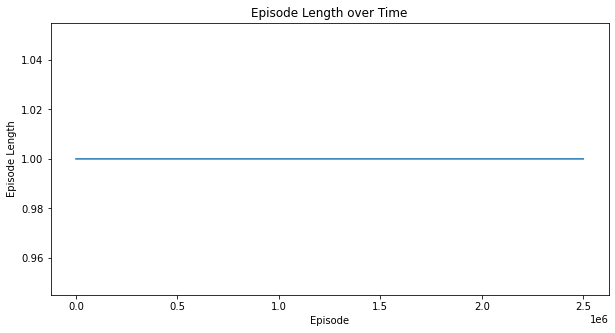

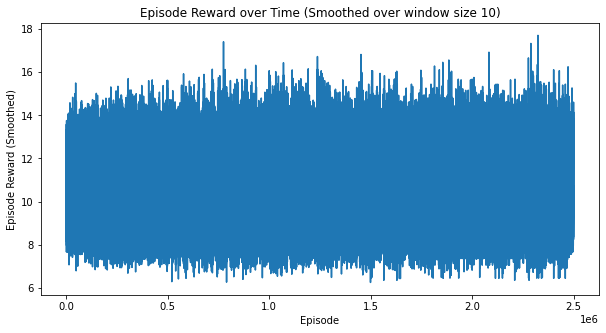

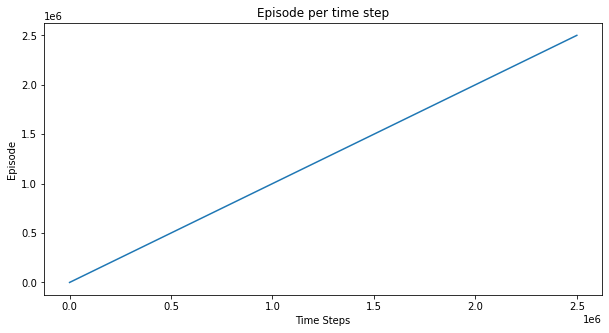

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [6]:
plotting.plot_episode_stats(stats) 

In [7]:
for key in Q.keys():
    print("Key:", key)
    print("State-Action Values:", Q[key], sep="\n")
    print("Best Action (Investment in risky asset):", decode_action(np.argmax(Q[key]), actions))

Key: (0, 100)
State-Action Values:
[10.33084352 10.42914368 10.4764098  10.56452656 10.56450693 10.5645538
 10.56452181 10.56527031 10.56451223 10.56450102 10.5641811 ]
Best Action (Investment in risky asset): 0.7000000000000001
Key: (1, 190.0)
State-Action Values:
[13.78404875 13.89674361 13.95582519 13.9860642  14.08416331 14.11987394
 14.16343218 14.13771408 14.1809831  13.98869155 14.13466123]
Best Action (Investment in risky asset): 0.8
Key: (2, 380.0)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (1, 110.00000000000001)
State-Action Values:
[10.48808848 10.5480864  10.61838116 10.66151056 10.73548048 10.65167622
 10.71639881 10.73572883 10.73619214 10.74114592 10.5431777 ]
Best Action (Investment in risky asset): 0.9
Key: (2, 104.50000000000001)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (1, 85.0)
State-Action Values:
[9.21954446 9.28568124 9.32561385 9.34246

Best Action (Investment in risky asset): 0.0
Key: (2, 71.25)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 63.0)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 135.0)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 59.49999999999999)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 196.0)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 272.0)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 56.25)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 289.00000000000006)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset):

In [8]:
# How often was each action take in each state
for key, value in A.items():
    print("State: {}, Actions: {}".format(key, value))

State: (0, 100), Actions: [ 39275.  39241.  39258.  41339. 106114. 103666. 879656. 286283. 503967.
 357378. 103823.]
State: (1, 190.0), Actions: [  2038.   2067.   2071.   2048.   2075.   2261.   3774.   2109. 135640.
   2284.   3232.]
State: (1, 110.00000000000001), Actions: [ 770.  843.  822.  796. 1109.  849.  856.  776. 4533. 5439.  804.]
State: (1, 85.0), Actions: [1054. 1038. 1098. 1003.  994. 7004. 1020. 1029. 1103. 6688. 1018.]
State: (1, 180.0), Actions: [  2933.   2886.   2949.   2859.   2880.   2809.   2840. 181251.  10685.
   8927.   2954.]
State: (1, 50.0), Actions: [ 1909.  1956.  1886.  1910.  1978.  1855. 34273.  1886.  2378.  3398.
  4235.]
State: (1, 70.0), Actions: [  4312.   4423.   4416.   4356.   4442.   4401.   4686. 431913.   4484.
  15798.   4670.]
State: (1, 160.0), Actions: [  3485.   3571.   3644.   3499.   3638.   3596.  51114.  13743. 295601.
   3566.   6298.]
State: (1, 100.0), Actions: [ 1889.  1746.  1803.  1913.  1811.  1785. 16082.  1896.  1793.  6703

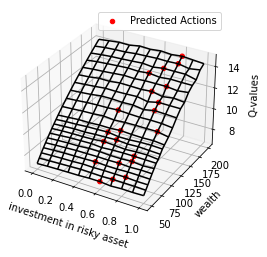

In [12]:
from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt
import random

def fun(x, y, Q, actions):
    return np.array([Q[(1,wealth)][encode_action(action, actions)] for action, wealth in zip(x,y)])
    

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = actions
y = np.array(sorted([wealth for t, wealth in Q.keys() if t == 1]))
X, Y = np.meshgrid(x, y)
zs = np.array(fun(np.ravel(X), np.ravel(Y), Q, actions))
Z = zs.reshape(X.shape)

# Predicted Actions for each state
states = [key for key in Q.keys() if key[0] == 1]
predicted_actions = [decode_action(np.argmax(Q[state]), actions) for state in states]
wealths = [wealth for _, wealth in states]
predicted_Q_values = [Q[state][np.argmax(Q[state])] for state in states]



ax.plot_wireframe(X, Y, Z, color="black")

ax.set_xlabel('investment in risky asset')
ax.set_ylabel('wealth')
ax.set_zlabel('Q-values')
ax.scatter(predicted_actions, wealths, predicted_Q_values, zdir="z", c="red", alpha=1, label="Predicted Actions")
ax.legend()

plt.show()

In [28]:
Q2, _, _ = qLearning(env, 5000)

Episode: 0, Mean Return: 8.986, Mean Wealth (V_T): 80.75, Epsilon: 1, Alpha: 1


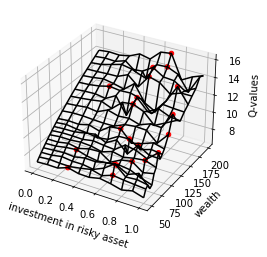

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = actions
y = np.array(sorted([wealth for t, wealth in Q2.keys() if t == 1]))
X, Y = np.meshgrid(x, y)
zs = np.array(fun(np.ravel(X), np.ravel(Y), Q2, actions))
Z = zs.reshape(X.shape)

# Predicted Actions for each state
states2 = [key for key in Q2.keys() if key[0] == 1]
predicted_actions2 = [decode_action(np.argmax(Q2[state]), actions) for state in states2]
wealths2 = [wealth for _, wealth in states2]
predicted_Q_values2 = [Q2[state][np.argmax(Q2[state])] for state in states2]

ax.plot_wireframe(X, Y, Z, color="black")

ax.set_xlabel('investment in risky asset')
ax.set_ylabel('wealth')
ax.set_zlabel('Q-values')
ax.scatter(predicted_actions2, wealths2, predicted_Q_values2, zdir="z", c="red", alpha=1)

plt.show()